# BBCA.JK Stock Price Forecasting Model Development

## Objective
Develop regression models to forecast next-day closing prices for BBCA.JK stock using engineered features from EDA.

## Models to Evaluate:
1. **XGBoost Regressor** (Primary) - Handles non-linear relationships and feature interactions
2. **Linear Regression** (Baseline) - Simple baseline with lagged features  
3. **Prophet** (Comparison) - Time series focused approach

## Target: Next-day closing price (regression)
## Evaluation Metrics: RMSE, MAE, R², MAPE

In [2]:
import json
import warnings
from datetime import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

import xgboost as xgb
import lightgbm as lgb
from prophet import Prophet

# Configuration
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 6)

# Reproducibility
np.random.seed(42)

/home/t0myam/projects/stock-forecast-modelling/idn-stock-forecasting-mlops/env/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [3]:
print("LOADING PREPROCESSED DATA")
print("=" * 75)

# Load preprocessed datasets
train_data = pd.read_csv('../data/preprocessed/bbca_train.csv', index_col='Date', parse_dates=True)
test_data = pd.read_csv('../data/preprocessed/bbca_test.csv', index_col='Date', parse_dates=True)

# Load feature metadata
with open('../data/preprocessed/feature_metadata.json', 'r') as f:
    feature_metadata = json.load(f)

print(f"Training data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")
print(f"Date range - Train: {train_data.index.min()} to {train_data.index.max()}")
print(f"Date range - Test: {test_data.index.min()} to {test_data.index.max()}")

# Display feature categories
print(f"\nFeature Categories:")
for category, features in feature_metadata.items():
    if category != 'target_columns':
        print(f"   • {category}: {len(features)} features")

print(f"   • Target variables: {feature_metadata['target_columns']}")

LOADING PREPROCESSED DATA
Training data shape: (573, 49)
Test data shape: (142, 49)
Date range - Train: 2022-08-01 00:00:00 to 2024-12-10 00:00:00
Date range - Test: 2024-12-11 00:00:00 to 2025-07-29 00:00:00

Feature Categories:
   • price_features: 17 features
   • volume_features: 3 features
   • ratio_features: 16 features
   • bounded_features: 1 features
   • normalized_features: 5 features
   • time_features: 4 features
   • Target variables: ['Target_Close_Next_Day', 'Target_Return_Next_Day', 'Target_Direction']


In [4]:
print("PREPARING DATA FOR MODELING")
print("=" * 75)

# Define feature columns (exclude target columns)
feature_columns = []
for category, features in feature_metadata.items():
    if category != 'target_columns':
        feature_columns.extend(features)

print(f"Total features for modeling: {len(feature_columns)}")

# Prepare training data
X_train = train_data[feature_columns].copy()
y_train = train_data['Target_Close_Next_Day'].copy()

# Prepare test data  
X_test = test_data[feature_columns].copy()
y_test = test_data['Target_Close_Next_Day'].copy()

# Remove any remaining NaN values
train_mask = ~(X_train.isnull().any(axis=1) | y_train.isnull())
test_mask = ~(X_test.isnull().any(axis=1) | y_test.isnull())

X_train = X_train[train_mask]
y_train = y_train[train_mask]
X_test = X_test[test_mask]
y_test = y_test[test_mask]

print(f"Final training samples: {len(X_train)}")
print(f"Final test samples: {len(X_test)}")
print(f"Features: {len(feature_columns)}")

# Display target statistics
print(f"\nTarget Variable Statistics:")
print(f"   • Training target range: {y_train.min():.2f} - {y_train.max():.2f}")
print(f"   • Test target range: {y_test.min():.2f} - {y_test.max():.2f}")
print(f"   • Training target mean: {y_train.mean():.2f}")
print(f"   • Test target mean: {y_test.mean():.2f}")

PREPARING DATA FOR MODELING
Total features for modeling: 46
Final training samples: 573
Final test samples: 142
Features: 46

Target Variable Statistics:
   • Training target range: 6970.16 - 10570.41
   • Test target range: 7775.00 - 9871.27
   • Training target mean: 8725.70
   • Test target mean: 8865.64


In [5]:
def evaluate_model(y_true, y_pred, model_name="Model"):
    """Calculate regression metrics"""
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    print(f"{model_name} Performance:")
    print(f"   • RMSE: {rmse:.2f}")
    print(f"   • MAE: {mae:.2f}")
    print(f"   • R²: {r2:.4f}")
    print(f"   • MAPE: {mape:.2f}%")
    
    return {
        'model': model_name,
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'mape': mape
    }

def plot_predictions(y_true, y_pred, model_name, dates=None):
    """Plot actual vs predicted values"""
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Time series plot
    if dates is not None:
        axes[0].plot(dates, y_true, label='Actual', alpha=0.7)
        axes[0].plot(dates, y_pred, label='Predicted', alpha=0.7)
        axes[0].set_xlabel('Date')
    else:
        axes[0].plot(y_true, label='Actual', alpha=0.7)
        axes[0].plot(y_pred, label='Predicted', alpha=0.7)
        axes[0].set_xlabel('Sample')
    
    axes[0].set_ylabel('Price (IDR)')
    axes[0].set_title(f'{model_name}: Actual vs Predicted')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Scatter plot
    axes[1].scatter(y_true, y_pred, alpha=0.6)
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    axes[1].plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8)
    axes[1].set_xlabel('Actual Price (IDR)')
    axes[1].set_ylabel('Predicted Price (IDR)')
    axes[1].set_title(f'{model_name}: Prediction Accuracy')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

BASELINE MODEL: LINEAR REGRESSION
Training Performance:
Linear Regression (Train) Performance:
   • RMSE: 104.00
   • MAE: 79.21
   • R²: 0.9838
   • MAPE: 0.90%

Test Performance:
Linear Regression (Test) Performance:
   • RMSE: 243.95
   • MAE: 201.99
   • R²: 0.7136
   • MAPE: 2.32%


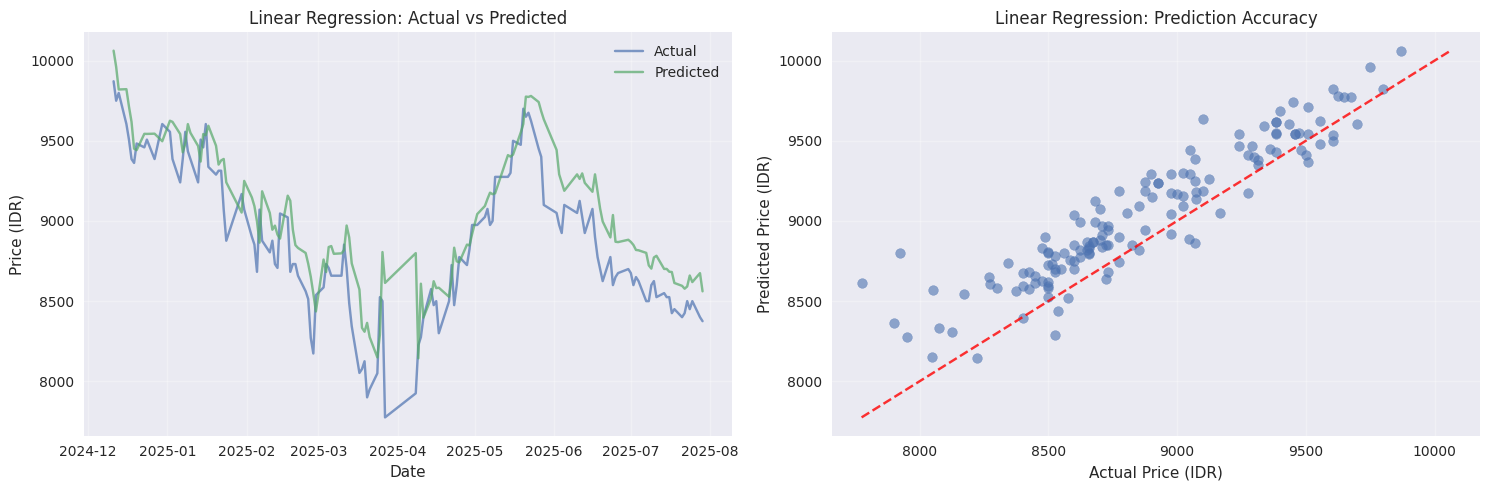


Top 10 Most Important Features (Linear Regression):
   42. Price_Change_1D: 11341.1562
   14. Close_Lag_1: 7324.6552
   4. Close: 6991.3324
   22. Log_Return: 2069.8226
   21. Daily_Return: 761.7081
   30. Price_Change_Pct_1D: 761.7081
   23. Intraday_Return: 552.7002
   24. Overnight_Return: 422.2579
   1. Open: 341.0586
   15. Close_Lag_2: 288.7263


In [6]:
print("BASELINE MODEL: LINEAR REGRESSION")
print("=" * 75)

# Train Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predictions
lr_train_pred = lr_model.predict(X_train)
lr_test_pred = lr_model.predict(X_test)

# Evaluate
print("Training Performance:")
lr_train_results = evaluate_model(y_train, lr_train_pred, "Linear Regression (Train)")

print("\nTest Performance:")
lr_test_results = evaluate_model(y_test, lr_test_pred, "Linear Regression (Test)")

# Plot results
plot_predictions(y_test, lr_test_pred, "Linear Regression", test_data.index[test_mask])

# Feature importance (top 10)
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': np.abs(lr_model.coef_)
}).sort_values('importance', ascending=False)

print(f"\nTop 10 Most Important Features (Linear Regression):")
for i, row in feature_importance.head(10).iterrows():
    print(f"   {i+1}. {row['feature']}: {row['importance']:.4f}")

In [7]:
print("REGULARIZED BASELINE: RIDGE REGRESSION")
print("=" * 75)

# Train Ridge Regression with cross-validation for alpha
from sklearn.linear_model import RidgeCV
ridge_model = RidgeCV(alphas=[0.1, 1.0, 10.0, 100.0], cv=5)
ridge_model.fit(X_train, y_train)

print(f"Best alpha: {ridge_model.alpha_}")

# Predictions
ridge_train_pred = ridge_model.predict(X_train)
ridge_test_pred = ridge_model.predict(X_test)

# Evaluate
print("\nTraining Performance:")
ridge_train_results = evaluate_model(y_train, ridge_train_pred, "Ridge Regression (Train)")

print("\nTest Performance:")
ridge_test_results = evaluate_model(y_test, ridge_test_pred, "Ridge Regression (Test)")

REGULARIZED BASELINE: RIDGE REGRESSION
Best alpha: 10.0

Training Performance:
Ridge Regression (Train) Performance:
   • RMSE: 105.64
   • MAE: 80.32
   • R²: 0.9833
   • MAPE: 0.92%

Test Performance:
Ridge Regression (Test) Performance:
   • RMSE: 205.07
   • MAE: 168.49
   • R²: 0.7976
   • MAPE: 1.93%


PRIMARY MODEL: XGBOOST REGRESSOR
Training samples: 458
Validation samples: 115
Best iteration: 87

Training Performance:
XGBoost (Train) Performance:
   • RMSE: 370.53
   • MAE: 161.63
   • R²: 0.7943
   • MAPE: 1.63%

Test Performance:
XGBoost (Test) Performance:
   • RMSE: 242.31
   • MAE: 185.93
   • R²: 0.7174
   • MAPE: 2.07%


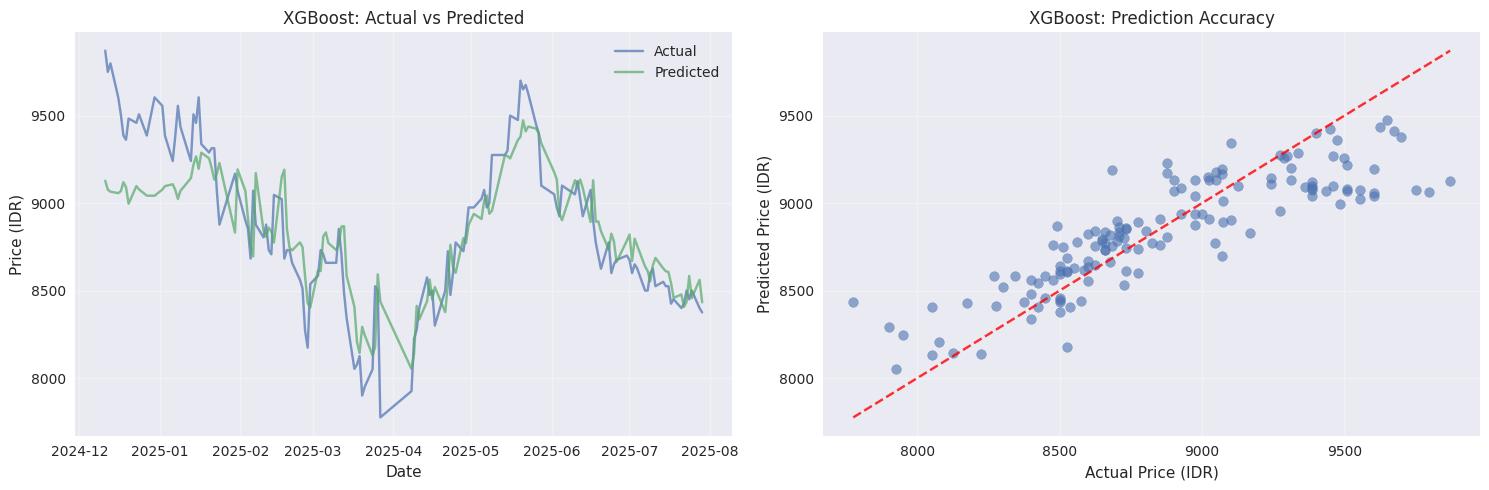


Top 15 Most Important Features (XGBoost):
   4. Close: 0.6255
   2. High: 0.1432
   3. Low: 0.1005
   5. SMA_5: 0.0539
   8. SMA_200: 0.0114
   11. BB_Upper: 0.0099
   1. Open: 0.0066
   17. Close_Rolling_Mean_20: 0.0066
   14. Close_Lag_1: 0.0060
   10. EMA_26: 0.0034
   12. BB_Middle: 0.0033
   32. Price_vs_SMA50: 0.0023
   15. Close_Lag_2: 0.0021
   9. EMA_12: 0.0020
   13. BB_Lower: 0.0015


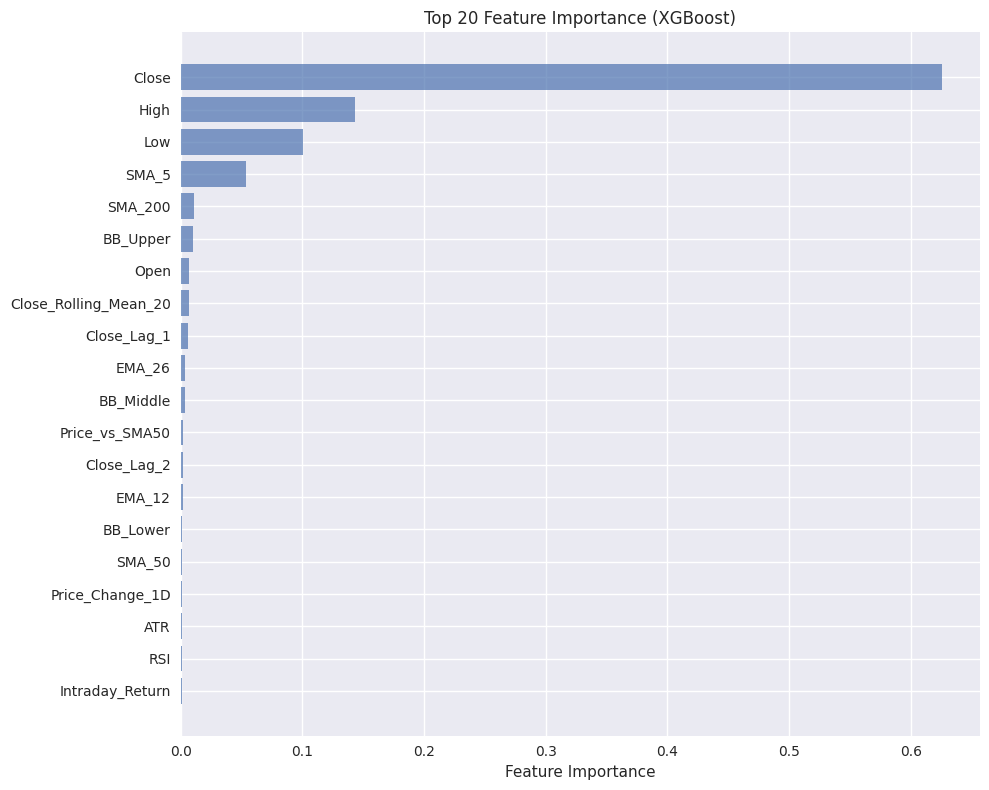

In [9]:
print("PRIMARY MODEL: XGBOOST REGRESSOR")
print("=" * 75)

# XGBoost parameters (tuned for time series)
xgb_params = {
    'n_estimators': 1000,
    'max_depth': 6,
    'learning_rate': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': 42,
    'n_jobs': -1,
    'early_stopping_rounds': 50,
}

# Train XGBoost
xgb_model = xgb.XGBRegressor(**xgb_params)

# Use early stopping with validation set (last 20% of training data)
split_idx = int(len(X_train) * 0.8)
X_train_fit = X_train.iloc[:split_idx]
y_train_fit = y_train.iloc[:split_idx]
X_val = X_train.iloc[split_idx:]
y_val = y_train.iloc[split_idx:]

print(f"Training samples: {len(X_train_fit)}")
print(f"Validation samples: {len(X_val)}")

# Fit with early stopping
xgb_model.fit(
    X_train_fit, y_train_fit,
    eval_set=[(X_val, y_val)],
    verbose=False
)

print(f"Best iteration: {xgb_model.best_iteration}")

# Predictions
xgb_train_pred = xgb_model.predict(X_train)
xgb_test_pred = xgb_model.predict(X_test)

# Evaluate
print("\nTraining Performance:")
xgb_train_results = evaluate_model(y_train, xgb_train_pred, "XGBoost (Train)")

print("\nTest Performance:")
xgb_test_results = evaluate_model(y_test, xgb_test_pred, "XGBoost (Test)")

# Plot results
plot_predictions(y_test, xgb_test_pred, "XGBoost", test_data.index[test_mask])

# Feature importance
xgb_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\nTop 15 Most Important Features (XGBoost):")
for i, row in xgb_importance.head(15).iterrows():
    print(f"   {i+1}. {row['feature']}: {row['importance']:.4f}")

# Plot feature importance
plt.figure(figsize=(10, 8))
top_features = xgb_importance.head(20)
plt.barh(range(len(top_features)), top_features['importance'], alpha=0.7)
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance')
plt.title('Top 20 Feature Importance (XGBoost)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [10]:
print("LIGHTGBM MODEL")
print("=" * 75)

# LightGBM parameters
lgb_params = {
    'n_estimators': 1000,
    'max_depth': 6,
    'learning_rate': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': 42,
    'n_jobs': -1,
    'verbose': -1,
}

# Train LightGBM
lgb_model = lgb.LGBMRegressor(**lgb_params)
lgb_model.fit(
    X_train_fit, y_train_fit,
    eval_set=[(X_val, y_val)],
    callbacks=[lgb.early_stopping(50), lgb.log_evaluation(0)]
)

# Predictions
lgb_train_pred = lgb_model.predict(X_train)
lgb_test_pred = lgb_model.predict(X_test)

# Evaluate
print("Training Performance:")
lgb_train_results = evaluate_model(y_train, lgb_train_pred, "LightGBM (Train)")

print("\nTest Performance:")
lgb_test_results = evaluate_model(y_test, lgb_test_pred, "LightGBM (Test)")

LIGHTGBM MODEL
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[48]	valid_0's l2: 266740
Training Performance:
LightGBM (Train) Performance:
   • RMSE: 237.02
   • MAE: 126.49
   • R²: 0.9158
   • MAPE: 1.32%

Test Performance:
LightGBM (Test) Performance:
   • RMSE: 206.69
   • MAE: 165.04
   • R²: 0.7944
   • MAPE: 1.89%


PROPHET TIME SERIES MODEL


05:29:16 - cmdstanpy - INFO - Chain [1] start processing
05:29:17 - cmdstanpy - INFO - Chain [1] done processing


Test Performance:
Prophet (Test) Performance:
   • RMSE: 308.93
   • MAE: 268.71
   • R²: 0.5407
   • MAPE: 3.10%


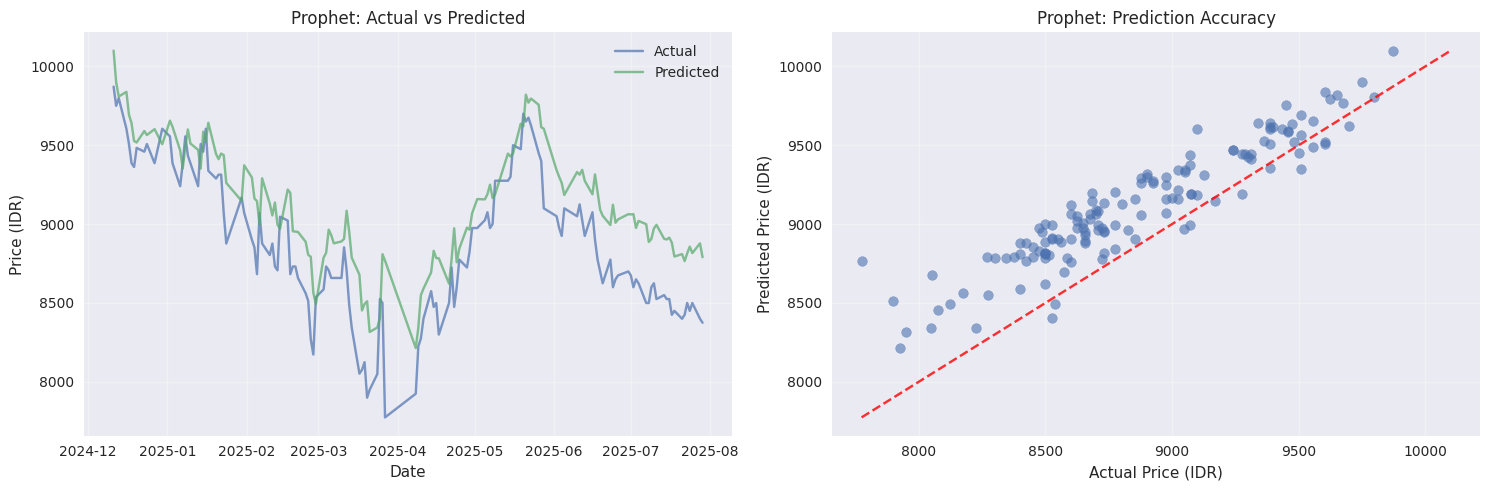

In [11]:
print("PROPHET TIME SERIES MODEL")
print("=" * 75)

# Prepare data for Prophet
# Prophet requires 'ds' (date) and 'y' (target) columns
prophet_train = pd.DataFrame({
    'ds': train_data.index[train_mask],
    'y': y_train
})

# Add additional regressors (key features only to avoid overfitting)
key_features = ['Close', 'SMA_20', 'RSI', 'Volume_vs_MA', 'DayOfWeek']
for feature in key_features:
    if feature in X_train.columns:
        prophet_train[feature] = X_train[feature].values

# Initialize and fit Prophet model
prophet_model = Prophet(
    daily_seasonality=True,
    weekly_seasonality=True,
    yearly_seasonality=True,
    changepoint_prior_scale=0.05
)

# Add regressors
for feature in key_features:
    if feature in prophet_train.columns:
        prophet_model.add_regressor(feature)

# Fit model
prophet_model.fit(prophet_train)

# Prepare test data for Prophet
prophet_test = pd.DataFrame({
    'ds': test_data.index[test_mask]
})

for feature in key_features:
    if feature in X_test.columns:
        prophet_test[feature] = X_test[feature].values

# Make predictions
prophet_pred = prophet_model.predict(prophet_test)
prophet_test_pred = prophet_pred['yhat'].values

# Evaluate
print("Test Performance:")
prophet_test_results = evaluate_model(y_test, prophet_test_pred, "Prophet (Test)")

# Plot Prophet results
plot_predictions(y_test, prophet_test_pred, "Prophet", test_data.index[test_mask])
    

MODEL COMPARISON SUMMARY
Model Rankings (by RMSE):
   2. Ridge Regression (Test): RMSE=205.07, R²=0.7976, MAPE=1.93%
   4. LightGBM (Test): RMSE=206.69, R²=0.7944, MAPE=1.89%
   3. XGBoost (Test): RMSE=242.31, R²=0.7174, MAPE=2.07%
   1. Linear Regression (Test): RMSE=243.95, R²=0.7136, MAPE=2.32%
   5. Prophet (Test): RMSE=308.93, R²=0.5407, MAPE=3.10%


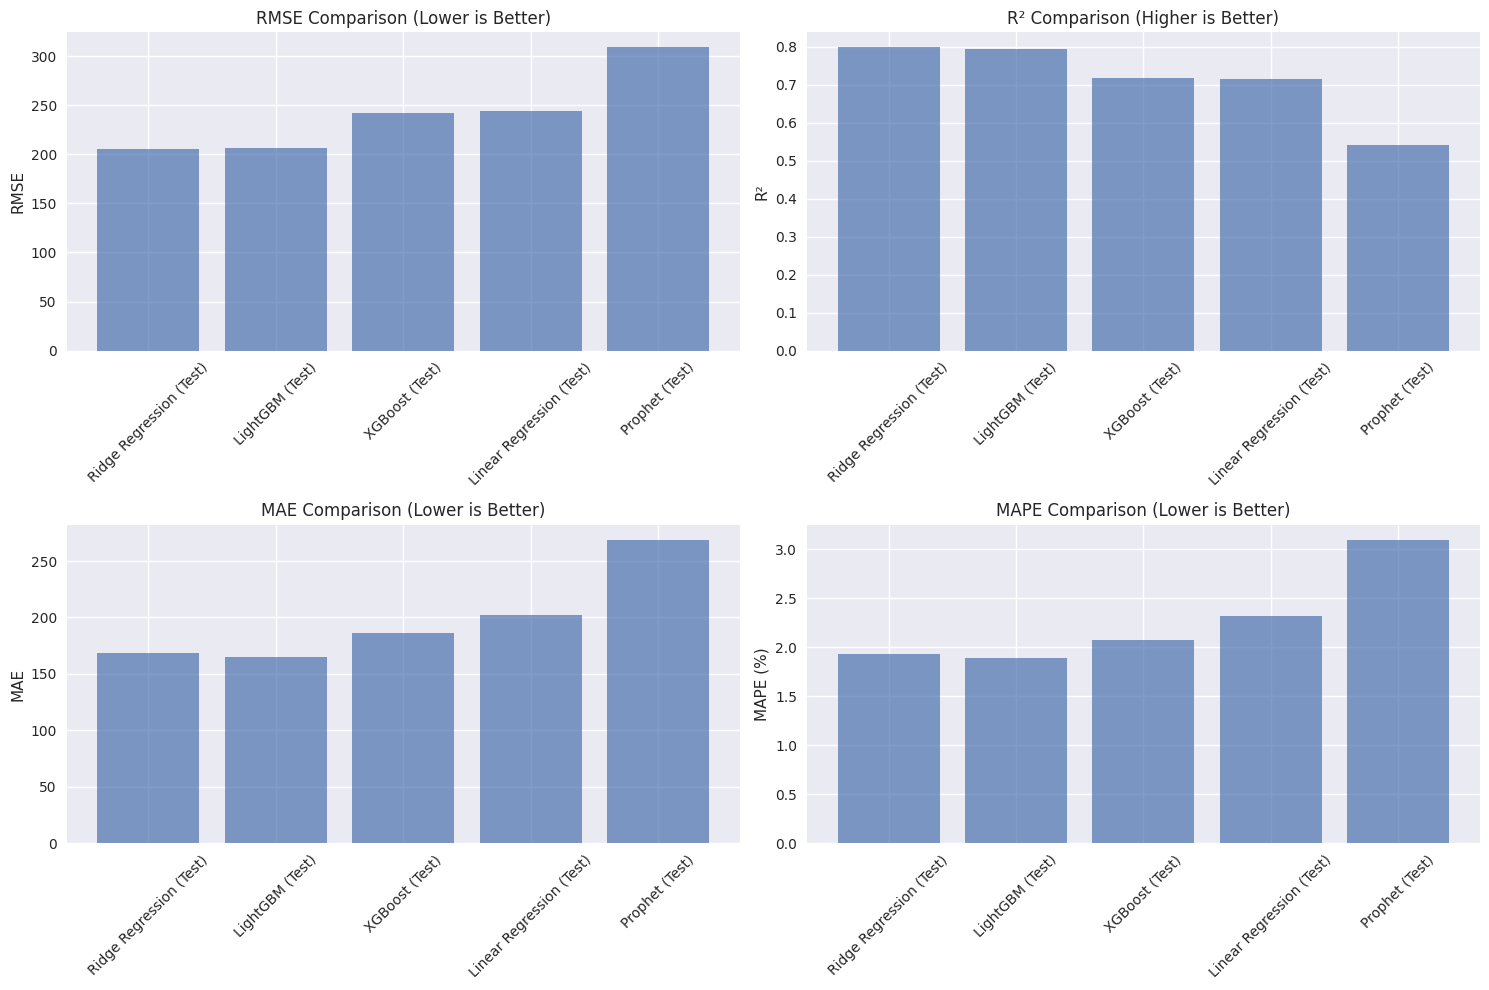

In [12]:
print("MODEL COMPARISON SUMMARY")
print("=" * 75)

# Compile results
results_df = pd.DataFrame([
    lr_test_results,
    ridge_test_results, 
    xgb_test_results,
    lgb_test_results
])

results_df = pd.concat([results_df, pd.DataFrame([prophet_test_results])], ignore_index=True)

# Sort by RMSE (lower is better)
results_df = results_df.sort_values('rmse')

print("Model Rankings (by RMSE):")
for i, row in results_df.iterrows():
    print(f"   {i+1}. {row['model']}: RMSE={row['rmse']:.2f}, R²={row['r2']:.4f}, MAPE={row['mape']:.2f}%")

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# RMSE comparison
axes[0,0].bar(results_df['model'], results_df['rmse'], alpha=0.7)
axes[0,0].set_title('RMSE Comparison (Lower is Better)')
axes[0,0].set_ylabel('RMSE')
axes[0,0].tick_params(axis='x', rotation=45)

# R² comparison
axes[0,1].bar(results_df['model'], results_df['r2'], alpha=0.7)
axes[0,1].set_title('R² Comparison (Higher is Better)')
axes[0,1].set_ylabel('R²')
axes[0,1].tick_params(axis='x', rotation=45)

# MAE comparison
axes[1,0].bar(results_df['model'], results_df['mae'], alpha=0.7)
axes[1,0].set_title('MAE Comparison (Lower is Better)')
axes[1,0].set_ylabel('MAE')
axes[1,0].tick_params(axis='x', rotation=45)

# MAPE comparison
axes[1,1].bar(results_df['model'], results_df['mape'], alpha=0.7)
axes[1,1].set_title('MAPE Comparison (Lower is Better)')
axes[1,1].set_ylabel('MAPE (%)')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

BEST MODEL: Ridge Regression (Test)
Residual Analysis:
   • Mean residual: -136.81
   • Std residual: 153.31
   • Min residual: -801.09
   • Max residual: 295.65


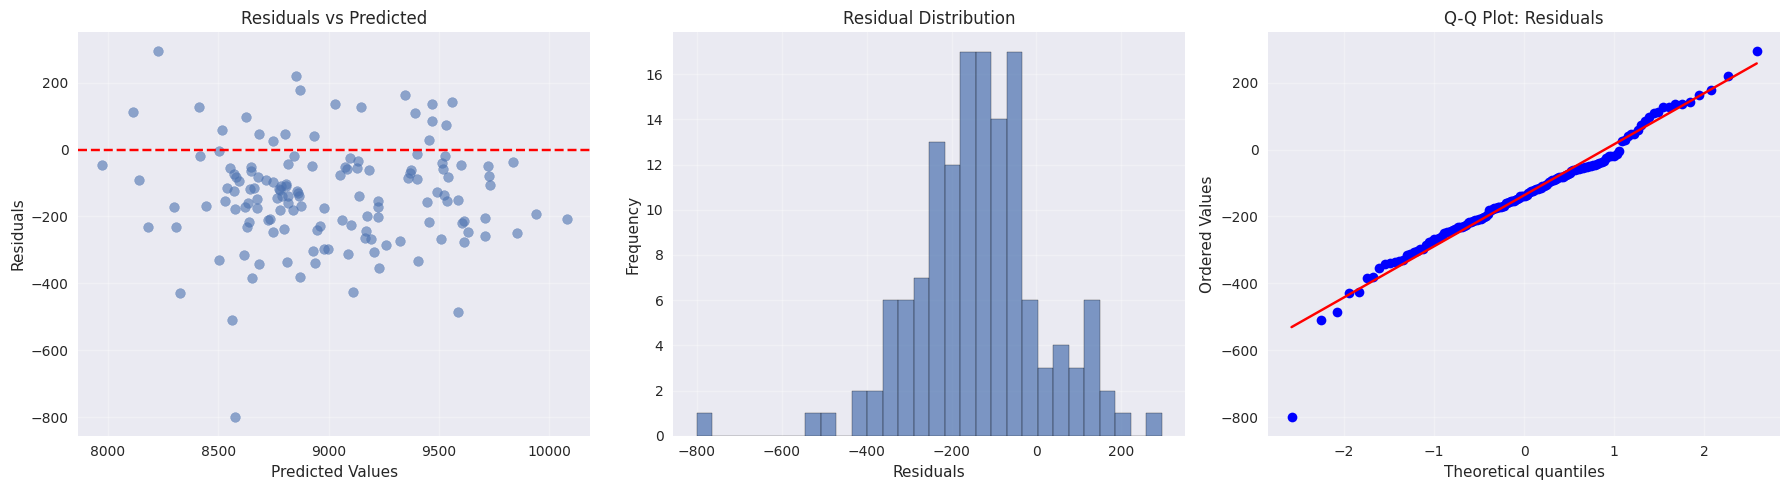

In [13]:
best_model_name = results_df.iloc[0]['model']
print(f"BEST MODEL: {best_model_name}")
print("=" * 75)

# Select best model object
if 'XGBoost' in best_model_name:
    best_model = xgb_model
    best_pred = xgb_test_pred
    feature_imp = xgb_importance
elif 'LightGBM' in best_model_name:
    best_model = lgb_model
    best_pred = lgb_test_pred
    feature_imp = pd.DataFrame({
        'feature': feature_columns,
        'importance': lgb_model.feature_importances_
    }).sort_values('importance', ascending=False)
elif 'Ridge' in best_model_name:
    best_model = ridge_model
    best_pred = ridge_test_pred
    feature_imp = pd.DataFrame({
        'feature': feature_columns,
        'importance': np.abs(ridge_model.coef_)
    }).sort_values('importance', ascending=False)
else:
    best_model = lr_model
    best_pred = lr_test_pred
    feature_imp = feature_importance

# Detailed analysis of predictions
residuals = y_test - best_pred
residual_stats = {
    'mean': residuals.mean(),
    'std': residuals.std(),
    'min': residuals.min(),
    'max': residuals.max()
}

print(f"Residual Analysis:")
print(f"   • Mean residual: {residual_stats['mean']:.2f}")
print(f"   • Std residual: {residual_stats['std']:.2f}")
print(f"   • Min residual: {residual_stats['min']:.2f}")
print(f"   • Max residual: {residual_stats['max']:.2f}")

# Residual plots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Residuals vs predicted
axes[0].scatter(best_pred, residuals, alpha=0.6)
axes[0].axhline(y=0, color='r', linestyle='--')
axes[0].set_xlabel('Predicted Values')
axes[0].set_ylabel('Residuals')
axes[0].set_title('Residuals vs Predicted')
axes[0].grid(True, alpha=0.3)

# Residual histogram
axes[1].hist(residuals, bins=30, alpha=0.7, edgecolor='black')
axes[1].set_xlabel('Residuals')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Residual Distribution')
axes[1].grid(True, alpha=0.3)

# Q-Q plot for residuals
from scipy import stats
stats.probplot(residuals, dist="norm", plot=axes[2])
axes[2].set_title('Q-Q Plot: Residuals')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [14]:
print("SAVING BEST MODEL")
print("=" * 75)

import joblib
import os

# Create models directory
os.makedirs('../models', exist_ok=True)

# Save best model
model_path = f'../models/best_model_{best_model_name.lower().replace(" ", "_")}.pkl'
joblib.dump(best_model, model_path)

# Save feature importance
feature_imp_path = '../models/feature_importance.csv'
feature_imp.to_csv(feature_imp_path, index=False)

# Save model metadata
model_metadata = {
    'model_type': best_model_name,
    'best_rmse': float(results_df.iloc[0]['rmse']),
    'best_r2': float(results_df.iloc[0]['r2']),
    'best_mae': float(results_df.iloc[0]['mae']),
    'best_mape': float(results_df.iloc[0]['mape']),
    'training_samples': len(X_train),
    'test_samples': len(X_test),
    'features_used': feature_columns,
    'top_10_features': feature_imp.head(10)['feature'].tolist(),
    'train_date_range': [str(train_data.index.min()), str(train_data.index.max())],
    'test_date_range': [str(test_data.index.min()), str(test_data.index.max())],
    'created_date': datetime.now().isoformat()
}

metadata_path = '../models/model_metadata.json'
with open(metadata_path, 'w') as f:
    json.dump(model_metadata, f, indent=2)

print(f"Model saved: {model_path}")
print(f"Feature importance saved: {feature_imp_path}")
print(f"Metadata saved: {metadata_path}")

SAVING BEST MODEL
Model saved: ../models/best_model_ridge_regression_(test).pkl
Feature importance saved: ../models/feature_importance.csv
Metadata saved: ../models/model_metadata.json


In [15]:
print("MODELING SUMMARY & CONCLUSIONS")
print("=" * 75)

print(f"**Best Performing Model**: {best_model_name}")
print(f"   • RMSE: {results_df.iloc[0]['rmse']:.2f} IDR")
print(f"   • R²: {results_df.iloc[0]['r2']:.4f}")
print(f"   • MAE: {results_df.iloc[0]['mae']:.2f} IDR") 
print(f"   • MAPE: {results_df.iloc[0]['mape']:.2f}%")

print(f"\n**Model Insights**:")
print(f"   • Training period: {len(X_train)} samples")
print(f"   • Test period: {len(X_test)} samples")
print(f"   • Feature count: {len(feature_columns)}")

print(f"\n**Top 5 Most Important Features**:")
for i, feature in enumerate(feature_imp.head(5)['feature'], 1):
    print(f"   {i}. {feature}")

print(f"\n**Model Performance Assessment**:")
if results_df.iloc[0]['r2'] > 0.15:
    print("   Model shows good predictive power (R² > 0.15)")
else:
    print("   Model shows limited predictive power (R² < 0.15)")

if results_df.iloc[0]['mape'] < 5.0:
    print("      Model has good accuracy (MAPE < 5%)")
elif results_df.iloc[0]['mape'] < 10.0:
    print("   Model has moderate accuracy (MAPE 5-10%)")
else:
    print("   Model needs improvement (MAPE > 10%)")

print(f"\n**Next Steps**:")
print("   1. Hyperparameter tuning for best model")
print("   2. Ensemble methods combining multiple models")
print("   3. Feature engineering refinement")
print("   4. Real-time prediction pipeline development")
print("   5. Production deployment with monitoring")

print(f"\n**Model Development Complete!**")
print(f"Ready for production deployment and further optimization.")

MODELING SUMMARY & CONCLUSIONS
**Best Performing Model**: Ridge Regression (Test)
   • RMSE: 205.07 IDR
   • R²: 0.7976
   • MAE: 168.49 IDR
   • MAPE: 1.93%

**Model Insights**:
   • Training period: 573 samples
   • Test period: 142 samples
   • Feature count: 46

**Top 5 Most Important Features**:
   1. High
   2. Low
   3. Open
   4. Close
   5. Close_Lag_1

**Model Performance Assessment**:
   Model shows good predictive power (R² > 0.15)
      Model has good accuracy (MAPE < 5%)

**Next Steps**:
   1. Hyperparameter tuning for best model
   2. Ensemble methods combining multiple models
   3. Feature engineering refinement
   4. Real-time prediction pipeline development
   5. Production deployment with monitoring

**Model Development Complete!**
Ready for production deployment and further optimization.
